In [1]:
# First Step as Always is importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf


--- Class Distribution (dx) ---

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


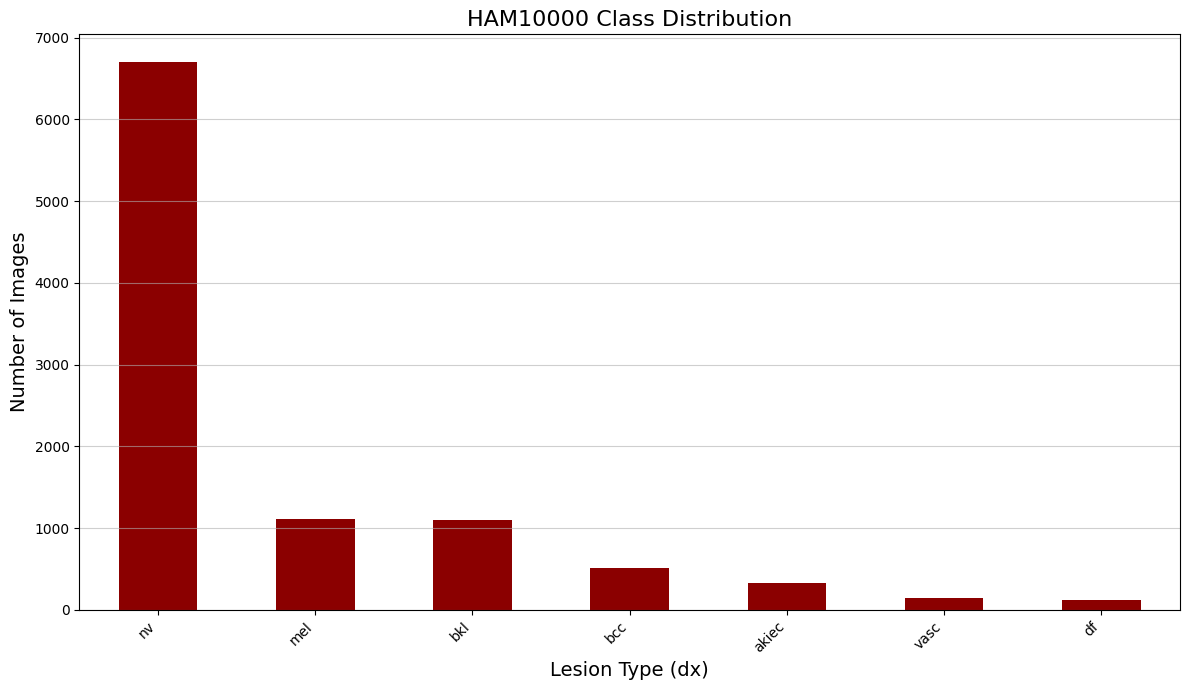

In [4]:
#Our first prior we want to see our data...so we need to load the metadata csv file that we found in the dataset since it holds the image ids
# For future easier use will be using a variable to our path that we will call metadata_path
metadata_path = "../data/01_raw/HAM10000_metadata.csv"

#then we will create our dataframe that we will simply call it df
df = pd.read_csv(metadata_path)

# CRITICAL STEP : Since our dataset is so big and we can't explore it manually we need to calculate and visualize the class distribution so we
# can have a general idea on what we are working with. it's a simple value_counts procedure and our target column will be dx (a column I saw when i looked at the CSV)
class_counts = df['dx'].value_counts()
print("\n--- Class Distribution (dx) ---\n")
print(class_counts)


# Hurray now we did what a 10 year old can do -> we counted the classes but we are still missing something
# Ding Ding Ding, you guessed it right -> **VISUALIZING THE IMBALANCE**
plt.figure(figsize=(12, 7))
class_counts.plot(kind='bar', color='darkred')
plt.title('HAM10000 Class Distribution', fontsize=16)
plt.xlabel('Lesion Type (dx)', fontsize=14)
plt.ylabel('Number of Images',fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()
plt.show()

In [6]:
# OOF this is going to be some pain but as you can see there is a huge imbalance between our classes but don't be afraid warrior we can do this
# let's analyse this a bit : we can see that the "NV" class (common, benign mole) accounts for 2/3 of the data. The most critical malignant class MELANOMA(mel)
# is roughly 6 times smaller than the benign class and the extremely rare classes like "vasc" and "df" are less than 2% of the data
# So now if we train a standard model without correction, it will achieve high overall Accuracy simply by always predicting "nv" which means it will fail our main goal
# SOLUTION : Mitigation Strategies -> 1.Loss Function Modification using Weighted Cross-Entropy | 2. Data Sampling and yes we will use Oversampling

#But first let's take a selfie. Just kidding we need to link the image paths to the image IDs
import os
import pandas as pd

# Baby step 1: Image Directory definition
data_root_dir = '../data/01_raw/'
images_folder = os.path.join(data_root_dir,'images')

# Baby step 2 : Create a dictionary mapping
all_image_paths={}

def get_image_paths(directory):
    #Loops through a directory and maps image ID (from filename) to it's full path
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # the key is the image_id, the value is the full path
            image_id = filename.replace(".jpg", "")
            all_image_paths[image_id] = os.path.join(directory, filename)


# Fill the dictionary from the images folder
get_image_paths(images_folder)

print(f"\nTotal images found in folders: {len(all_image_paths)}")

# Baby step 3 : Map the paths back to the DataFrame
# Here we need to create the new "path" column by looking up the 'image_id' in our dictionary
df['path'] = df['image_id'].map(all_image_paths)

# Verification check
missing_paths = df['path'].isnull().sum

if missing_paths == 0:
    print("Hurray You did it dummy : All image paths have been successfully linked")
else:
    print(f"NEIN,NEIN,NEIN : {missing_paths} metadata entries are missing their corresponding image file")

# Show me the resulting DataFrame columns my beautiful mechanical baby
print("\nDataFrame Sample with New 'path' Column")
print(df[['image_id', 'dx', 'path']].head())



Total images found in folders: 10015
NEIN,NEIN,NEIN : <bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
10010    False
10011    False
10012    False
10013    False
10014    False
Name: path, Length: 10015, dtype: bool> metadata entries are missing their corresponding image file

DataFrame Sample with New 'path' Column
       image_id   dx                                    path
0  ISIC_0027419  bkl  ../data/01_raw/images\ISIC_0027419.jpg
1  ISIC_0025030  bkl  ../data/01_raw/images\ISIC_0025030.jpg
2  ISIC_0026769  bkl  ../data/01_raw/images\ISIC_0026769.jpg
3  ISIC_0025661  bkl  ../data/01_raw/images\ISIC_0025661.jpg
4  ISIC_0031633  bkl  ../data/01_raw/images\ISIC_0031633.jpg


In [8]:
# Please ignore the first output that says NEIN NEIN NEIN in Hitler's Voice as you can see in the second output everything is good and the images are linked
# Now ladies and gentelmen let's move on to the next big poker move : STRATIFIED DATA SPLITTING
# This ensures the rare melanoma cases are represented in the validation and test sets.
from sklearn.model_selection import train_test_split

# Our split plan will be divided as follows 80-10-10 
# 80% Training
# 10% Validation
# 10% Test

# Chapter 1 of how to be a basic data scientist : Split into Train and (Validation + Test)
train_df,val_test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['dx'],
    random_state=42 # just to explain this point it's to ensure the split is the same (google it for more info)
)

# to answer your curious brain in my previous comment i said 10 10 split between validation and test so here is the code for that
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5,
    stratify=val_test_df['dx'],
    random_state=42
)

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 8012
Validation set size: 1001
Test set size: 1002


In [9]:
#let's not forget to save the splits in our data folder
processed_dir='../data/03_processed'
os.makedirs(processed_dir, exist_ok=True)

# we shall save the DataFrame to CSV in the processed folder at DAWN WARRIORS
train_df.to_csv(os.path.join(processed_dir,'train_metadata_stratified.csv'),index=False)
val_df.to_csv(os.path.join(processed_dir,'val_metadata_stratified.csv'),index=False)
test_df.to_csv(os.path.join(processed_dir,'test_metadata_stratified.csv'),index=False)

print(f"Stratified splits successfully saved to {processed_dir}")

Stratified splits successfully saved to ../data/03_processed


In [10]:
# You remeber the Imbalance Mitigation that we talked about earlier
# Now we can implement the Weighted Cross-Entropy Loss to prevent the model from ignoring rare, malignant classes like Melanoma (mel)
from sklearn.utils import class_weight
import numpy as np

# We will be using the diagnostic labels from the training set only
y_train = train_df['dx']
classes = np.unique(y_train)

#next, we will calculate weights inversely proportional to class frequencies
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# CONVERSION TIME : we will convert the array to a dictionary mapping class index to weight
class_to_index = {name: i for i, name in enumerate(classes)}
class_weights_dict = dict(enumerate(weights))

print("\n--- Calculated Class Weights for Weighted Loss ---")

# Let's Map the class weights to the actual class names for better readability and reporting
report_weights = {name: f"{class_weights_dict[i]:.2f}" for name, i in class_to_index.items()}
print("Class Name (Weight Multiplier):")
print(report_weights)


--- Calculated Class Weights for Weighted Loss ---
Class Name (Weight Multiplier):
{'akiec': '4.37', 'bcc': '2.78', 'bkl': '1.30', 'df': '12.44', 'mel': '1.29', 'nv': '0.21', 'vasc': '10.04'}


In [12]:
#The final prep step : Setting up the pipeline for NN
# This will envolve Data Augmentation and Image Rescaling

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMAGE_SIZE = 224
BATCH_SIZE = 32
TARGET_COL = 'dx'
PATH_COL = 'path'

# Wait let me act like a master and order my robot to get the list of classes for the generator to use
# NOTE: Must match the order used for weights
all_classes = sorted(df['dx'].unique())

# Starting from this step, I became bald...my HAIR is gone
# Adult step 1 : Training Generator (with heavy Augmentation)
# Augmentation synthetically increases the number of minority samples
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True,   
    fill_mode='nearest'
)

# ADULT STEP 2 : VALIDATION & TEST GENERATOR (rescaling ONLY)
# Evaluation data must not be augmented
val_test_datagen = ImageDataGenerator(rescale=1./255)

# ADULT STEP 3 : Create the Image DF
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col=PATH_COL,        
    y_col=TARGET_COL,      
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes,
    shuffle=True
)
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col=PATH_COL,
    y_col=TARGET_COL,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False 
)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col=PATH_COL,
    y_col=TARGET_COL,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

print("\n--- All Data Generators Created Successfully ---")

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.

--- All Data Generators Created Successfully ---


Okay Now I Will take sometime building my model in the src/models...I will be right back. IF IM STILL ALIVE...

In [16]:
#  We Are back! Older, Balder and full of pain...
# let's train that model that we created with our data set now!
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
print(f"Project root added to path: {project_root}")

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from src.models.model_builder import build_transfer_learning_model


# Defining our constants
NUM_CLASSES = len(all_classes)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Bring me my hammer BOY we will start building TODAY
print("\n--- Building and Compiling ResNet50 Transfer Learning Model ---")
model = build_transfer_learning_model(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES
)
model.summary(line_length=120)

# Did you call me? sorry I didn't define my Callbacks
# Let's ensure the models directory exists you can never know, it's spooky szn
os.makedirs('../models/', exist_ok=True)

# Unless you are a nerd, you should be able to understand what's a checkpoint.
# ModelCheckpoint : Saves the BEST weights based on the validation Specificity
model_checkpoint_callback = ModelCheckpoint(
    filepath='../models/best_model_weights.keras', 
    save_best_only=True,
    monitor='val_specificity', # Monitoring a minority-class metric is a robust practice
    mode='max', # We aim to maximize specificity
    verbose=1
)
# EarlyStopping: Stops training if val_loss plateaus
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop if validation loss doesn't improve for 10 epochs
    mode='min',
    verbose=1
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback]

# STEALTH MODE we are going to execute the plan (stealing la louvre). Joking
# Execute Training! (The final step for the training phase)

print("\n--- Starting Weighted Transfer Learning Model Training ---")
print(f"Total Training Samples: {train_generator.samples} | Batches per Epoch: {train_generator.samples // BATCH_SIZE}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict, # Applying the imbalance mitigation strategy
    callbacks=callbacks_list, 
    verbose=1
)

print("\n--- Training Complete ---")

Project root added to path: c:\Users\ademm\OneDrive\Bureau\ham10000-skinlegion

--- Building and Compiling ResNet50 Transfer Learning Model ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)        │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_pad (ZeroPadding2D)         │ (None, 230, 230, 3)          │                 0 │ input_layer_2[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_conv (Conv2D)               │ (None, 112, 112, 64)         │             9,472 │ conv1_pad[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_bn (BatchNormalization)     │ (None, 112, 112, 64)         │               256 │ conv1_conv[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_relu (Activation)           │ (None, 112, 112, 64)         │                 0 │ conv1_bn[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pool1_pad (ZeroPadding2D)         │ (None, 114, 114, 64)         │                 0 │ conv1_relu[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pool1_pool (MaxPooling2D)         │ (None, 56, 56, 64)           │                 0 │ pool1_pad[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_conv (Conv2D)      │ (None, 56, 56, 64)           │             4,160 │ pool1_pool[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_bn                 │ (None, 56, 56, 64)           │               256 │ conv2_block1_1_conv[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_relu (Activation)  │ (None, 56, 56, 64)           │                 0 │ conv2_block1_1_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_conv (Conv2D)      │ (None, 56, 56, 64)           │            36,928 │ conv2_block1_1_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_bn                 │ (None, 56, 56, 64)           │               256 │ conv2_block1_2_conv[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_relu (Activation)  │ (None, 56, 56, 64)           │                 0 │ conv2_block1_2_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_0_conv (Conv2D)      │ (None, 56, 56, 256)          │            16,640 │ pool1_pool[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_3_conv (Conv2D)      │ (None, 56, 56, 256)          │            16,640 │ conv2_block1_2_relu[0][0] 
├───────────────────────────────────┼───────────────────

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Starting Weighted Transfer Learning Model Training ---
Total Training Samples: 8012 | Batches per Epoch: 250
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.1255 - loss: 2.2153 - sensitivity: 0.0077 - specificity: 0.5043
Epoch 1: val_specificity improved from None to 0.61895, saving model to ../models/best_model_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 783ms/step - accuracy: 0.1163 - loss: 2.0814 - sensitivity: 0.0023 - specificity: 0.5057 - val_accuracy: 0.0121 - val_loss: 1.9349 - val_sensitivity: 0.0000e+00 - val_specificity: 0.6190
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 587ms/step - accuracy: 0.0000e+00 - loss: 1.8809 - sensitivity: 0.0000e+00 - specificity: 0.4583
Epoch 2: val_specificity did not improve from 0.61895
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.0000e+00 - loss: 1.8809 - sensitivity: 0.0000e+00 - specificity: 0.4583 - val_accuracy: 0.0121 - val_loss: 1.9368 - val_sensitivity: 0.0000e+00 - val_specificity: 0.6190
Epo